<a href="https://colab.research.google.com/github/carloslara99/Fraud_detector/blob/master/Fraud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud detection Kernel

In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"carloslara99","key":"b13a73d56cdb5004e54693fc0864dc8b"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission
!chmod 600 ~/.kaggle/kaggle.json


## Load Data

In [0]:
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip test_identity.csv.zip

Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_transaction.csv   
Archive:  train_identity.csv.zip
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_identity.csv      
Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_transaction.csv    
Archive:  test_identity.csv.zip
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_identity.csv       


In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import re
import gc,os,sys

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

In [0]:
train_trn = pd.read_csv('./train_transaction.csv')
test_trn = pd.read_csv('./test_transaction.csv')
train_id = pd.read_csv('./train_identity.csv')
test_id = pd.read_csv('./test_identity.csv')


print(train_trn.shape, test_trn.shape)
print(train_id.shape, test_id.shape)


(590540, 394) (506691, 393)
(144233, 41) (141907, 41)


## Reduce Memory Usage

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [0]:
train_id = reduce_mem_usage(train_id)
train_trn = reduce_mem_usage(train_trn)
test_id = reduce_mem_usage(test_id)
test_trn = reduce_mem_usage(test_trn)

Memory usage after optimization is: 25.86 MB
Decreased by 0.0%
Memory usage after optimization is: 542.35 MB
Decreased by 0.0%
Memory usage after optimization is: 25.44 MB
Decreased by 0.0%
Memory usage after optimization is: 472.59 MB
Decreased by 0.0%


In [0]:
print(train_trn.shape, test_trn.shape)
print(train_id.shape, test_id.shape)

(590540, 394) (506691, 393)
(144233, 41) (141907, 41)


In [0]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
train_trn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prepare data for analysis
Merge  Transaction and Identity files and delete original files

In [0]:
train = pd.merge(train_trn, train_id, on='TransactionID', how='left')
test = pd.merge(test_trn, test_id, on='TransactionID', how='left')

,0,1
isFraud,0.96501,0.03499


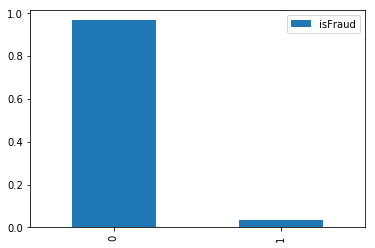

In [0]:
fc = train['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

### Cleaning data of missing values

In [0]:
train_missing_val = pd.DataFrame(train.notnull().sum().sort_values(ascending=False))
train_perc_miss = train_missing_val/len(train) * 100
pd.concat([train_missing_val, train_perc_miss], keys = ['miss Value', 'no miss %'], axis = 1)

,miss Value,no miss %
,0,0
TransactionID,590540,100.000000
C5,590540,100.000000
C14,590540,100.000000
C13,590540,100.000000
C12,590540,100.000000
C11,590540,100.000000
C10,590540,100.000000
C9,590540,100.000000
C7,590540,100.000000


In [0]:
limit=90 #leave only columns w/ more than 90% data

In [0]:
#Select final columns
train_new = train_missing_val[train_perc_miss>limit].index 

train_new = train[train.columns.intersection(columns_final)]

In [0]:
train_new.shape

(590540, 112)

## Prepare data with categorical values

In [0]:
#Show categorical variables
train_new[train_new.select_dtypes(include=['object']).columns]

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit
5,W,visa,debit
6,W,visa,debit
7,W,visa,debit
8,H,visa,debit
9,W,mastercard,debit


In [0]:
card6_dummy_df = pd.get_dummies(train_new["card6"])

In [0]:
train_new = pd.concat([train_new,card6_dummy_df],axis=1)

In [0]:
train_new = train_new._get_numeric_data()
train_new = train_new.dropna()

# Model Engineering

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

x_new = train_new.drop(["isFraud"],axis=1)
y_new = train_new["isFraud"]

## Logistic Regression

In [0]:
lr = LogisticRegression(solver='lbfgs')  
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_predict = lr.predict(X_test)
accuracy_score(y_predict, y_test)

0.9658530678614057

In [0]:
pd.crosstab(y_test, y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,All
True,,
0,279175,279175
1,9870,9870
All,289045,289045


In [0]:
print(classification_report(y_test, y_predict))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    279175
           1       0.00      0.00      0.00      9870

    accuracy                           0.97    289045
   macro avg       0.48      0.50      0.49    289045
weighted avg       0.93      0.97      0.95    289045



In [0]:
recall_score(y_test, y_predict)

0.0

In [0]:
print(confusion_matrix(y_test, y_predict.round()))

[[279175      0]
 [  9870      0]]


## Random Forest model

In [0]:
from sklearn.ensemble import RandomForestClassifier
# train model
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
# predict on test set
rfc_pred = rfc.predict(X_test)

In [0]:
print(confusion_matrix(y_test, rfc_pred.round()))

[[278684    491]
 [  5809   4061]]


In [0]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    279175
           1       0.89      0.41      0.56      9870

    accuracy                           0.98    289045
   macro avg       0.94      0.70      0.78    289045
weighted avg       0.98      0.98      0.97    289045



In [0]:
pd.crosstab(y_test, rfc_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,278684,491,279175
1,5809,4061,9870
All,284493,4552,289045


## Conclusions


1.   RF shows better precision than logistic regression  
2.   Other algorithms can be tried


